In [ ]:
!pip install -Uqq 'fastai' 'ddgs'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [ ]:
from ddgs import DDGS
from fastcore.all import *
import time, json
from fastdownload import download_url # This is for downloading urls
from fastai.vision.all import * # This is for handling and displaying images

def search_images(keywords, max_images=200):
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [ ]:
# Gather the training data required for training the model
searches = ('bird','plane')
path = Path('bird_or_plane')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photos'))
    time.sleep(5)

In [ ]:
# Verify and delete malfunctioning image files
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)
len(failed)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


23

In [ ]:
# Create Data Blocks for training the model
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

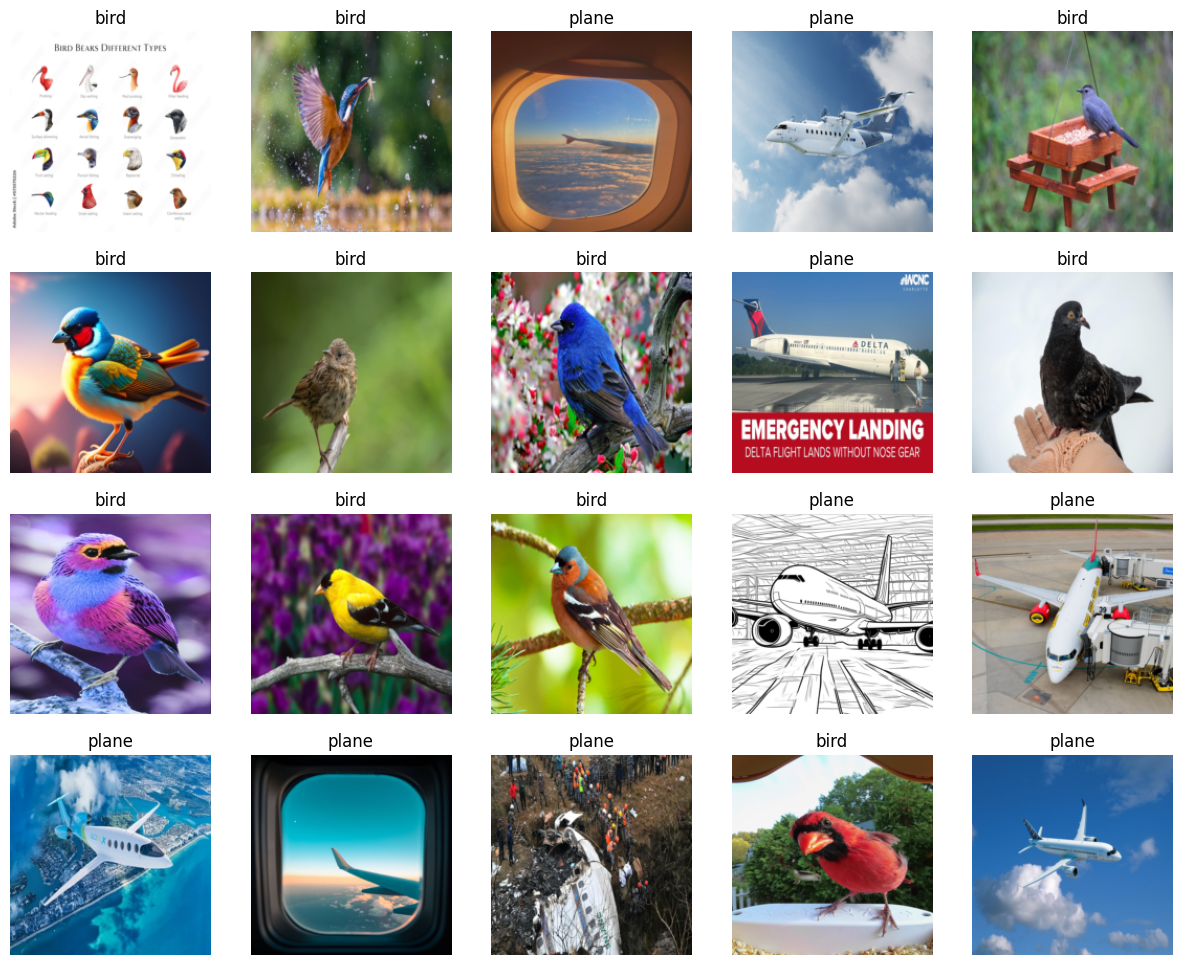

In [ ]:
dls.show_batch(max_n=20)

In [ ]:
#Train the Model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


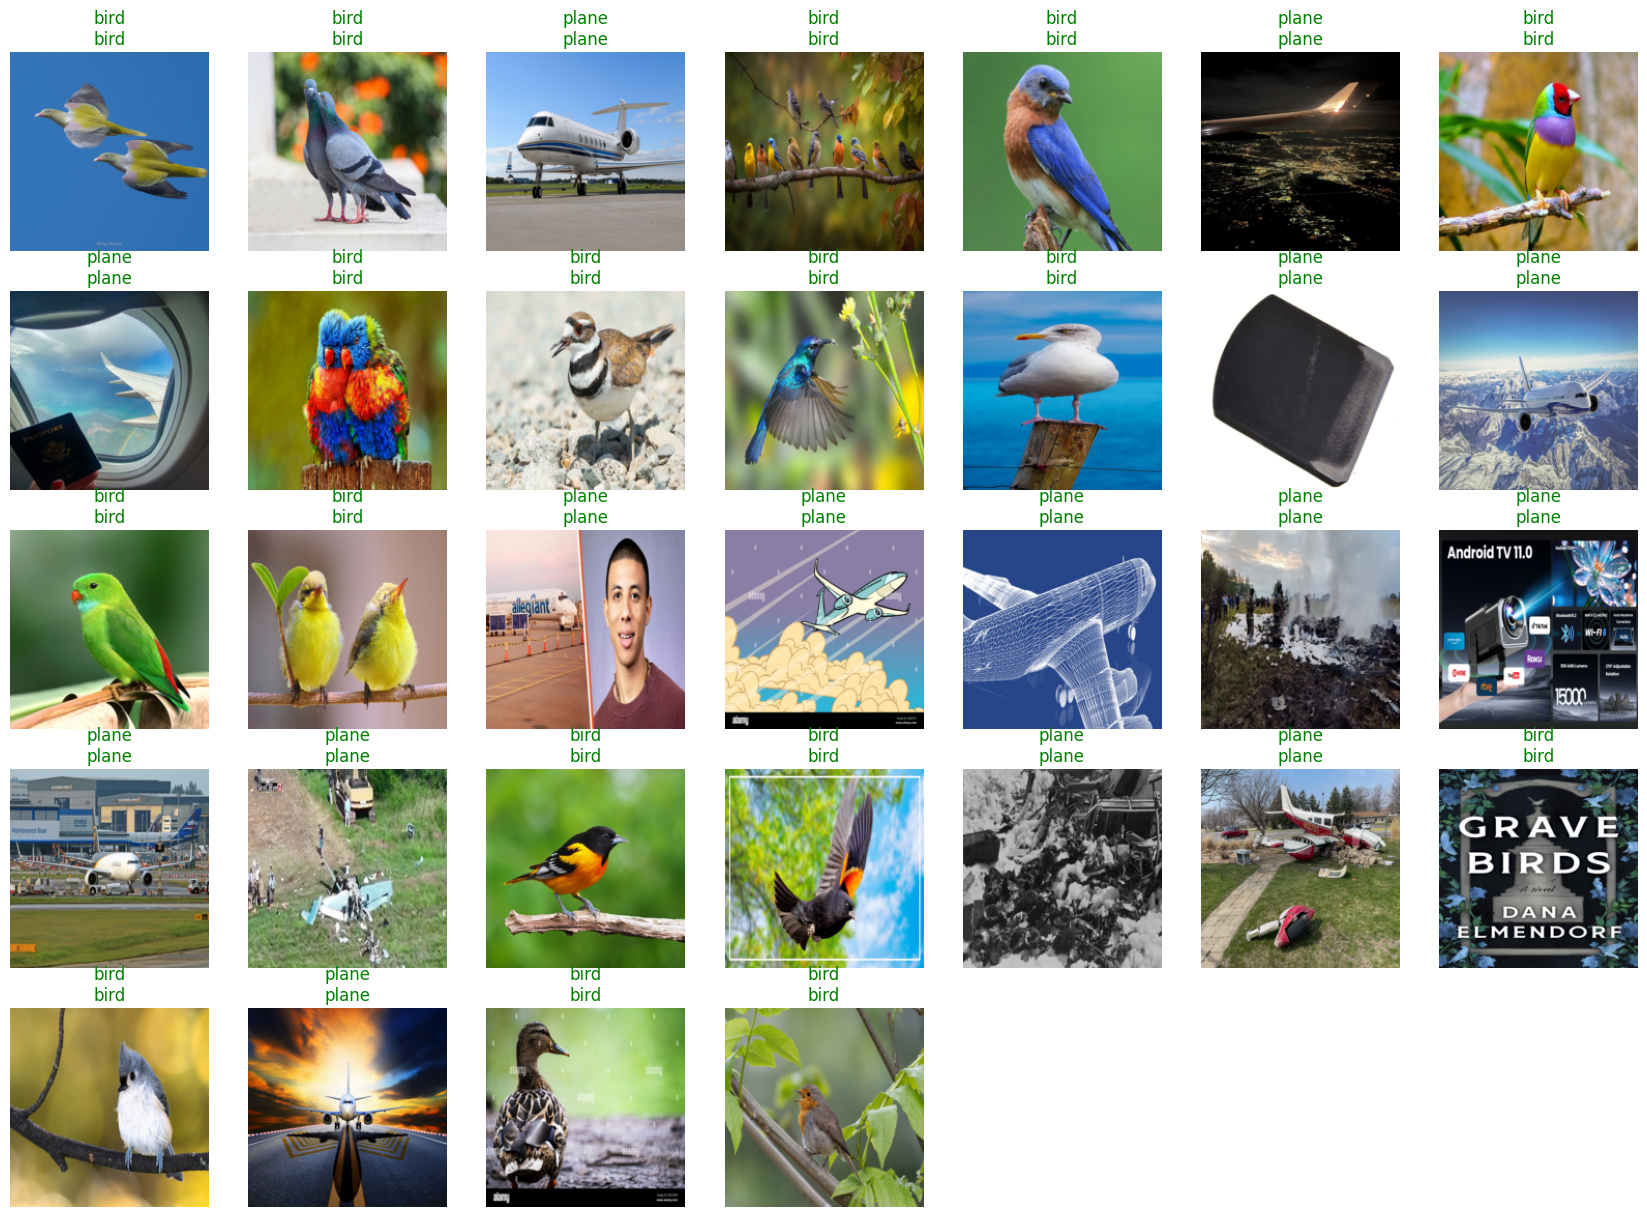

In [ ]:
learn.show_results(max_n=100)

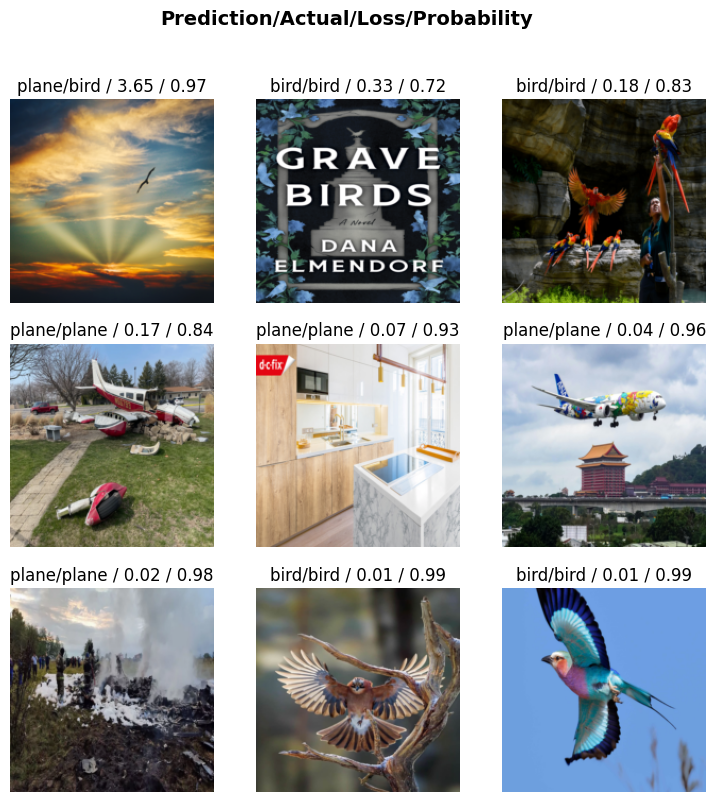

In [ ]:
# Plot top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, nrows=3)

In [ ]:
# Clean data with fastai GUI
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Apply the changes
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/'images'/cat)